# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Lab 4</font>
## <font color='blue'>Detecção de Câncer em Imagens com Deep Learning</font>

![DSA](imagens/Lab4.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
!pip install -q torch==1.13.0

In [4]:
!pip install -q pytorch-lightning==1.8.3

In [5]:
# Imports

# Manipulação de dados e imagens
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Pytorch
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Pacotes para o relatório de hardware
import gc
import types
import pkg_resources
import pytorch_lightning as pl

# Seed para reproduzir os mesmos resultados
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pytorch_lightning: 1.8.3
numpy            : 1.21.5
cv2              : 4.7.0
torchvision      : 0.14.0
torch            : 1.13.0
pandas           : 1.4.4
matplotlib       : 3.5.2
PIL              : 9.2.0



## Verificando o Hardware

In [7]:
# Relatório completo

# Verificando o dispositivo
processing_device = "cuda" if torch.cuda.is_available() else "cpu"

# Verificando se GPU pode ser usada (isso depende da plataforma CUDA estar instalada)
torch_aval = torch.cuda.is_available()

# Labels para o relatório de verificação
lable_1 = 'Visão Geral do Ambiente'
lable_2 = 'Se NVIDIA-SMI não for encontrado, então CUDA não está disponível'
lable_3 = 'Fim da Checagem'

# Função para verificar o que está importado nesta sessão
def get_imports():

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):            
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}

        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

# Imports nesta sessão
imports = list(set(get_imports()))

# Loop para verificar os requerimentos
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
# Pasta com os dados (quando necessário)
pasta_dados = r'dados'

print(f'{lable_1:-^100}')
print()
print(f"Device:", processing_device)
print(f"Pasta de Dados: ", pasta_dados)
print(f"Versões dos Pacotes Requeridos: ", requirements)
print(f"Dispositivo Que Será Usado Para Treinar o Modelo: ", processing_device)
print(f"CUDA Está Disponível? ", torch_aval)
print("Versão do PyTorch: ", torch.__version__)
print("Versão do Lightning: ", pl.__version__)
print()
print(f'{lable_2:-^100}\n')
!nvidia-smi
gc.collect()
print()
print(f"Limpando a Memória da GPU (se disponível): ", torch.cuda.empty_cache())
print("\nModelo da GPU:")
# Modelo da GPU usada
!nvidia-smi --query-gpu=name --format=csv,noheader
print(f'\n{lable_3:-^100}')

--------------------------------------Visão Geral do Ambiente---------------------------------------

Device: cuda
Pasta de Dados:  dados
Versões dos Pacotes Requeridos:  [('Pillow', '9.2.0'), ('tqdm', '4.64.1'), ('matplotlib', '3.5.2'), ('numpy', '1.21.5'), ('torch', '1.13.0'), ('pandas', '1.4.4'), ('torchvision', '0.14.0')]
Dispositivo Que Será Usado Para Treinar o Modelo:  cuda
CUDA Está Disponível?  True
Versão do PyTorch:  1.13.0+cu117
Versão do Lightning:  1.8.3

------------------Se NVIDIA-SMI não for encontrado, então CUDA não está disponível------------------

Tue Mar 21 14:51:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compu

## Mapeamento das Imagens

Obtemos todos os caminhos das imagens e fazemos o match com as informações em HAM10000_metadata.csv.

In [8]:
# Pasta com as imagens
pasta_imagens = 'input'

In [9]:
# Obtém o caminho de cada imagem
caminho_imagens = glob(os.path.join(pasta_imagens, '*', '*.jpg'))

In [10]:
# Cria um dicionário
dict_map_imagem_caminho = {os.path.splitext(os.path.basename(x))[0]: x for x in caminho_imagens}

In [11]:
dict_map_imagem_caminho

{'ISIC_0031543': 'input/HAM10000_images_part_2/ISIC_0031543.jpg',
 'ISIC_0033578': 'input/HAM10000_images_part_2/ISIC_0033578.jpg',
 'ISIC_0031596': 'input/HAM10000_images_part_2/ISIC_0031596.jpg',
 'ISIC_0031025': 'input/HAM10000_images_part_2/ISIC_0031025.jpg',
 'ISIC_0031037': 'input/HAM10000_images_part_2/ISIC_0031037.jpg',
 'ISIC_0031048': 'input/HAM10000_images_part_2/ISIC_0031048.jpg',
 'ISIC_0030609': 'input/HAM10000_images_part_2/ISIC_0030609.jpg',
 'ISIC_0033338': 'input/HAM10000_images_part_2/ISIC_0033338.jpg',
 'ISIC_0029828': 'input/HAM10000_images_part_2/ISIC_0029828.jpg',
 'ISIC_0033845': 'input/HAM10000_images_part_2/ISIC_0033845.jpg',
 'ISIC_0031563': 'input/HAM10000_images_part_2/ISIC_0031563.jpg',
 'ISIC_0030179': 'input/HAM10000_images_part_2/ISIC_0030179.jpg',
 'ISIC_0032879': 'input/HAM10000_images_part_2/ISIC_0032879.jpg',
 'ISIC_0029834': 'input/HAM10000_images_part_2/ISIC_0029834.jpg',
 'ISIC_0029583': 'input/HAM10000_images_part_2/ISIC_0029583.jpg',
 'ISIC_003

In [12]:
# Leitura do arquivo de metadados
df_original = pd.read_csv(os.path.join(pasta_imagens, 'HAM10000_metadata.csv'))

In [13]:
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [14]:
# Adiciona o path
df_original['path'] = df_original['image_id'].map(dict_map_imagem_caminho.get)

In [15]:
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,input/HAM10000_images_part_2/ISIC_0031633.jpg


https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

In [16]:
# Tipos de lesões que serão analisadas
dict_tipo_lesao = {'nv': 'Melanocytic nevi',
                   'mel': 'dermatofibroma',
                   'bkl': 'Benign keratosis-like lesions ',
                   'bcc': 'Basal cell carcinoma',
                   'akiec': 'Actinic keratoses',
                   'vasc': 'Vascular lesions',
                   'df': 'Dermatofibroma'}

In [17]:
df_original['cell_type'] = df_original['dx'].map(dict_tipo_lesao.get)

In [18]:
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,input/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions


In [19]:
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

In [20]:
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,input/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


## Pré-Processamento

Realizaremos diversas tarefas de pré-processamento das imagens.

### Extraindo Média e Desvio Padrão das Imagens

Esta função é usada para calcular a média e o desvio padrão em todo o conjunto de dados e será usada para normalização das imagens de entrada.

In [21]:
# Função para cálculo de média e desvio
def calcula_img_mean_std(image_paths):

    # Define altura e largura que usaremos nas imagens
    img_h, img_w = 224, 224
    
    # Listas de controle
    imgs = []
    means, stdevs = [], []

    # Loop de leitura e resize das imagens
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    # Stack de imagens
    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    # Normalização
    imgs = imgs.astype(np.float32) / 255.

    # Loop de cálculo da média e desvio
    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    # BGR --> RGB
    means.reverse()  
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    
    return means, stdevs

In [22]:
# Retorna a média e o padrão de cada canal RGB.
norm_mean, norm_std = calcula_img_mean_std(caminho_imagens)

100%|██████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:56<00:00, 175.75it/s]


(224, 224, 3, 10015)
normMean = [0.7630361, 0.54564756, 0.57004404]
normStd = [0.14092882, 0.1526126, 0.16997065]


### Preparação do Dataset de Validação

In [23]:
# Vamos verificar quantas imagens estão associadas a cada lesion_id
df_undup = df_original.groupby('lesion_id').count()

In [24]:
df_undup.head()

,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
lesion_id,,,,,,,,,
HAM_0000000,2,2,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1,1,1


In [25]:
# Agora filtramos lesion_ids que possuem apenas uma imagem associada 
df_undup = df_undup[df_undup['image_id'] == 1]

In [26]:
# Reset do índice
df_undup.reset_index(inplace = True)

In [27]:
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [28]:
# Função para identificar lesion_ids que possuem imagens duplicadas e aqueles que possuem apenas uma imagem
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

In [29]:
# Cria uma nova coluna que seja uma cópia da coluna lesion_id
df_original['duplicates'] = df_original['lesion_id']

In [30]:
df_original.sample()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
1629,HAM_0003602,ISIC_0033004,mel,histo,30.0,female,upper extremity,input/HAM10000_images_part_2/ISIC_0033004.jpg,dermatofibroma,6,HAM_0003602


In [31]:
# Aplica a função a esta nova coluna
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)

In [32]:
df_original.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
9962,HAM_0005228,ISIC_0026702,akiec,histo,80.0,female,face,input/HAM10000_images_part_1/ISIC_0026702.jpg,Actinic keratoses,0,unduplicated
7037,HAM_0006856,ISIC_0028831,nv,histo,35.0,male,chest,input/HAM10000_images_part_1/ISIC_0028831.jpg,Melanocytic nevi,4,duplicated
1485,HAM_0000179,ISIC_0034046,mel,histo,45.0,male,back,input/HAM10000_images_part_2/ISIC_0034046.jpg,dermatofibroma,6,duplicated
8747,HAM_0004802,ISIC_0030966,nv,histo,45.0,female,back,input/HAM10000_images_part_2/ISIC_0030966.jpg,Melanocytic nevi,4,duplicated
7934,HAM_0007216,ISIC_0032962,nv,histo,30.0,male,back,input/HAM10000_images_part_2/ISIC_0032962.jpg,Melanocytic nevi,4,unduplicated


In [33]:
# Vamos contar as duplicatas
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [34]:
# Agora filtramos as imagens que não têm duplicatas
df_undup = df_original[df_original['duplicates'] == 'unduplicated']

In [35]:
df_undup.shape

(5514, 11)

In [36]:
# Agora criamos um val set usando df_undup porque temos certeza de que nenhuma dessas imagens tem duplicatas
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size = 0.2, random_state = 101, stratify = y)

In [37]:
df_val.shape

(1103, 11)

In [38]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

### Separação das Amostras de Treino e Validação

In [39]:
# Esta função identifica se uma imagem faz parte do conjunto train ou val
def get_val_rows(x):
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

In [40]:
# Identifica treino ou validação
df_original['train_or_val'] = df_original['image_id']

In [41]:
# Aplica a função a esta nova coluna
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)

In [42]:
# Filtra as linhas de treino
df_treino = df_original[df_original['train_or_val'] == 'train']

In [43]:
print(len(df_treino))
print(len(df_val))

8912
1103


In [44]:
df_treino['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [45]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

### Dataset Augmentation

Podemos ver que há um sério desequilíbrio de classe nos dados de treinamento. Para resolver esse problema usaremos Dataset Augmentation criando imagens sintéticas a partir das imagens originais. Leia o manual em pdf no Capítulo 7 do curso.

In [46]:
# Taxa de dataset augmentation a ser usada em cada classe
data_aug_rate = [15,10,5,50,0,40,5]

In [47]:
# Loop para o dataset augmentation
for i in range(7):
    
    if data_aug_rate[i]:
        
        # Equaliza a proporção de imagens por classe nos dados de treino
        # Geramos novas imagens multiplicando as imagens existentes pela taxa definida na lista de taxas
        df_treino = df_treino.append([df_treino.loc[df_treino['cell_type_idx'] == i,:]] * (data_aug_rate[i] - 1), 
                                     ignore_index = True)

In [48]:
df_treino['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [49]:
# Reset do índice
df_treino = df_treino.reset_index()

In [50]:
df_treino.shape

(35967, 13)

### Preparação das Amostras de Treino, Validação e Teste

In [51]:
# Podemos dividir o conjunto de validação em um conjunto de validação e um conjunto de teste
df_val, df_teste = train_test_split(df_val, test_size = 0.5)

In [52]:
# Reset do índice
df_val = df_val.reset_index()
df_teste = df_teste.reset_index()

In [53]:
df_val.shape

(551, 12)

In [54]:
df_teste.shape

(552, 12)

## Modelagem

Nesta etapa vamos constuir o processo de modelagem com 3 arquiteturas de Deep Learning. Leia os manuais em pdf no Capítulo 7 do curso.

### Função de Inicialização do Modelo e Definição de Arquitetura com Transfer Learning

In [55]:
# feature_extracting é um booleano que define se estamos fazendo um ajuste fino ou extração de recursos.
# Se feature_extracting = False, o modelo é ajustado e todos os parâmetros do modelo são atualizados.
# Se feature_extracting = True, apenas os parâmetros da última camada são atualizados, os outros permanecem fixos.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [56]:
# Função para inicializar diferentes arquiteturas de Deep Learning
def inicializa_modelo(model_name, num_classes, feature_extract, use_pretrained = True):

    model_ft = None
    input_size = 0

    # Usaremos o modelo resnet50
    if model_name == "resnet":
        
        # Tamanho (pixels) das imagens de entrada
        input_size = 224
        
        # Carregamos o modelo pré-treinado com todos os pesos
        model_ft = models.resnet50(pretrained = use_pretrained)
        
        # Treinamos o modelo e atualizamos os pesos durante o treinamento
        set_parameter_requires_grad(model_ft, feature_extract)
        
        # Define o número de atributos de entrada
        num_ftrs = model_ft.fc.in_features
        
        # Camada linear final para prever a probabilidade das 7 classes com as quais estamos trabalhando
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    # Usaremos o modelo Densenet121
    elif model_name == "densenet":
        
        # Tamanho (pixels) das imagens de entrada
        input_size = 224
        
        # Carregamos o modelo pré-treinado com todos os pesos
        model_ft = models.densenet121(pretrained = use_pretrained)
        
        # Treinamos o modelo e atualizamos os pesos durante o treinamento
        set_parameter_requires_grad(model_ft, feature_extract)
        
        # Define o número de atributos de entrada
        num_ftrs = model_ft.classifier.in_features
        
        # Camada linear final para prever a probabilidade das 7 classes com as quais estamos trabalhando
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    # Usaremos o Inception V3
    elif model_name == "inception":
        
        # Tamanho (pixels) das imagens de entrada
        # Tenha cuidado, pois espera-se (299 x 299) para o tamanho das imagens e ainda tem saída auxiliar
        input_size = 299

        # Carregamos o modelo pré-treinado com todos os pesos
        model_ft = models.inception_v3(pretrained = use_pretrained)
        
        # Treinamos o modelo e atualizamos os pesos durante o treinamento
        set_parameter_requires_grad(model_ft, feature_extract)
        
        # Tratando a auxilary net da arquitetura Inceptio
        model_ft.aux_logits = False
        
        # Tratando a primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    else:
        print("Modelo inválido...")
        exit()
        
    return model_ft, input_size

### Inicializando o Modelo Escolhido e Definindo Transformações

In [57]:
# Modelo que será treinado
#nome_modelo = 'densenet'
#nome_modelo = 'resnet'
nome_modelo = 'inception'

In [58]:
num_classes = 7

In [59]:
# Vamos treinar o modelo e sempre atualizar os pesos
feature_extract = False

In [60]:
# Inicializa o modelo
model_ft, input_size = inicializa_modelo(nome_modelo, num_classes, feature_extract, use_pretrained = True)

In [61]:
# Define o device
device = processing_device

In [62]:
# Coloca o modelo no device
model = model_ft.to(device)

In [63]:
# Transformações das imagens de treino
transform_treino = transforms.Compose([transforms.Resize((input_size,input_size)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                       transforms.ColorJitter(brightness = 0.1, contrast = 0.1, hue = 0.1),
                                       transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

In [64]:
# Transformações das imagens de validação
transform_val = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

### Criando os DataLoaders

In [65]:
# Defina um organizador de dados para modelo PyTorch 
class OrganizaDados(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [66]:
# Organiza e transforma os dados de treino
set_treino = OrganizaDados(df_treino, transform = transform_treino)

In [67]:
# Cria o dataloader de treino
loader_treino = DataLoader(set_treino, batch_size = 32, shuffle = True, num_workers = 4)

In [68]:
# O mesmo em validação
set_val = OrganizaDados(df_val, transform = transform_val)
loader_val = DataLoader(set_val, batch_size = 32, shuffle = False, num_workers = 4)

In [69]:
# O mesmo em teste
set_teste = OrganizaDados(df_teste, transform = transform_val)
loader_teste = DataLoader(set_teste, batch_size = 32, shuffle = False, num_workers = 4)

In [70]:
# Usaremos o otimizador Adam
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [71]:
# Usaremos cross entropy loss como função de perda
criterion = nn.CrossEntropyLoss().to(device)

## Treinamento

Nesta etapa treinaremos o modelo.

### Funções Para o Loop de Treino e Validação

In [72]:
# Função para calcular erro em treino e validação durante o treinamento
class CalculaMetricas(object):
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [73]:
# Listas para erro e acurácia em treino
total_loss_train, total_acc_train = [],[]

In [74]:
# Função de treino do modelo
def treina_modelo(treino_loader, model, criterion, optimizer, epoch):
    
    # Coloca o modelo em modo de treino
    model.train()
    
    # Inicializa objetos de cálculo de métricas
    train_loss = CalculaMetricas()
    train_acc = CalculaMetricas()
    
    # Iteração
    curr_iter = (epoch - 1) * len(treino_loader)
    
    # Loop de treino
    for i, data in enumerate(treino_loader):
        
        # Extra os dados
        images, labels = data
        
        # Tamanho da imagem
        N = images.size(0)
        
        # Coloca imagens e labels no device
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Zera os gradientes
        optimizer.zero_grad()
        
        # Previsão do modelo
        outputs = model(images)

        # Erro do modelo
        loss = criterion(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Obtem a previsão de maior probabilidade
        prediction = outputs.max(1, keepdim = True)[1]
        
        # Atualiza as métricas
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        
        # Iteração
        curr_iter += 1
        
        # Print e update das métricas
        # A condição *** and curr_iter < 1000 *** pode ser removida se você quiser treinar com o dataset completo
        if (i + 1) % 100 == 0 and curr_iter < 1000:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (epoch, 
                                                                                       i + 1, 
                                                                                       len(treino_loader), 
                                                                                       train_loss.avg, 
                                                                                       train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
            
    return train_loss.avg, train_acc.avg

In [75]:
# Listas para erro e acurácia em validação
total_loss_val, total_acc_val = [],[]

In [76]:
# Função para validação
def valida_modelo(val_loader, model, criterion, optimizer, epoch):
    
    # Coloca o modelo em modo de validação
    model.eval()
    
    # Inicializa objetos de cálculo de métricas
    val_loss = CalculaMetricas()
    val_acc = CalculaMetricas()
    
    # Validação
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            
            images, labels = data
            
            N = images.size(0)
            
            images = Variable(images).to(device)
            
            labels = Variable(labels).to(device)

            outputs = model(images)
            
            prediction = outputs.max(1, keepdim = True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    
    return val_loss.avg, val_acc.avg

### Treinamento do Modelo

In [77]:
# Hiperparâmetros
epoch_num = 3
best_val_acc = 0

In [78]:
%%time
for epoch in range(1, epoch_num + 1):
    
    # Execute a função de treino
    loss_train, acc_train = treina_modelo(loader_treino, model, criterion, optimizer, epoch)
    
    # Executa a função de validação
    loss_val, acc_val = valida_modelo(loader_val, model, criterion, optimizer, epoch)
    
    # Calcula as métricas
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    
    # Verifica a acurácia em validação
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('Melhor Resultado: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.34515], [train acc 0.52344]
[epoch 1], [iter 200 / 1124], [train loss 1.17815], [train acc 0.57484]
[epoch 1], [iter 300 / 1124], [train loss 1.09822], [train acc 0.60344]
[epoch 1], [iter 400 / 1124], [train loss 1.03762], [train acc 0.62391]
[epoch 1], [iter 500 / 1124], [train loss 0.99453], [train acc 0.63819]
[epoch 1], [iter 600 / 1124], [train loss 0.96127], [train acc 0.65125]
[epoch 1], [iter 700 / 1124], [train loss 0.92328], [train acc 0.66496]
[epoch 1], [iter 800 / 1124], [train loss 0.89427], [train acc 0.67469]
[epoch 1], [iter 900 / 1124], [train loss 0.86823], [train acc 0.68323]
------------------------------------------------------------
[epoch 1], [val loss 0.55960], [val acc 0.79836]
------------------------------------------------------------
*****************************************************
Melhor Resultado: [epoch 1], [val loss 0.55960], [val acc 0.79836]
*****************************************************
------

## Avaliação do Modelo

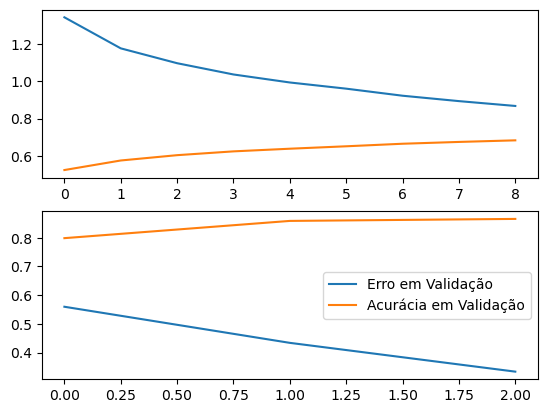

In [79]:
# Plot
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'Erro em Treino')
fig1.plot(total_acc_train, label = 'Acurácia em Treino')
fig2.plot(total_loss_val, label = 'Erro em Validação')
fig2.plot(total_acc_val, label = 'Acurácia em Validação')
plt.legend()
plt.show()

In [80]:
# Função de plot da confusion_matrix
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label Real')
    plt.xlabel('Label Previsto')

In [81]:
# Avaliação do modelo com dados de teste
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(loader_teste):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim = True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

In [82]:
# Cria a confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)

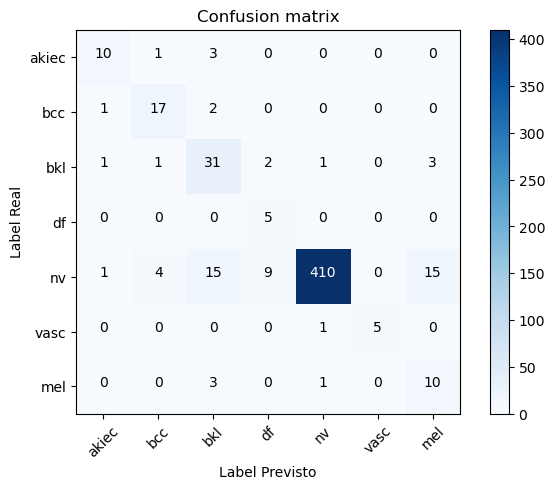

In [83]:
# Plot da confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [84]:
# Gera o relatório de classificação
report = classification_report(y_label, y_predict, target_names = plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.77      0.71      0.74        14
         bcc       0.74      0.85      0.79        20
         bkl       0.57      0.79      0.67        39
          df       0.31      1.00      0.48         5
          nv       0.99      0.90      0.95       454
        vasc       1.00      0.83      0.91         6
         mel       0.36      0.71      0.48        14

    accuracy                           0.88       552
   macro avg       0.68      0.83      0.72       552
weighted avg       0.93      0.88      0.90       552



Text(0, 0.5, 'Classificação Incorreta')

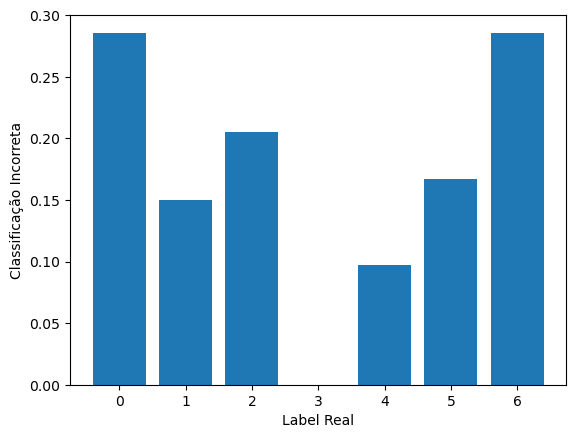

In [85]:
# Plot de erros por classe
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('Label Real')
plt.ylabel('Classificação Incorreta')

## Conclusão

- Conseguimos 0.87574 de acurácia com o modelo DenseNet.
- Conseguimos 0.86607 de acurácia com o modelo ResNet.
- Conseguimos 0.86533 de acurácia com o modelo Inception.

# Fim